In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import glob

In [3]:
training_dataset_dir = "/content/drive/MyDrive/richhf/train" if os.path.exists("/content/drive/MyDrive/richhf/train") else "./richhf/train"

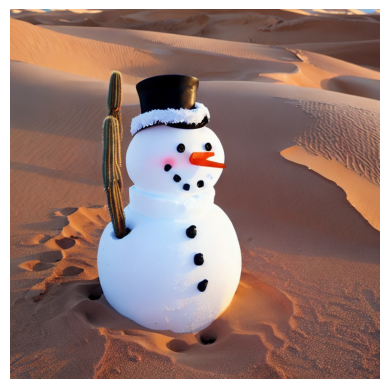

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import glob



# ディレクトリが存在するか確認
if os.path.exists(training_dataset_dir):
    # ディレクトリ内の最初のPNGファイルを検索
    png_files = glob.glob(os.path.join(training_dataset_dir, '*.png'))

    if png_files:
        # 最初のPNGファイルを参照
        img_path = png_files[0]

        # 画像を開いて表示
        image = Image.open(img_path)
        plt.imshow(image)
        plt.axis('off')  # 軸を非表示にする
        plt.show()
    else:
        print("PNGファイルが見つかりませんでした。")
else:
    print("指定されたディレクトリが存在しませんでした。")


In [5]:
train_data_csv = "/content/drive/MyDrive/richhf/RichHF_18K.csv" if os.path.exists("/content/drive/MyDrive/richhf") else "./richhf"

In [6]:
class MetaIQAPredictor(nn.Module):
    def __init__(self, input_size=3*512*512, hidden_size=1024, output_size=512):
        super(MetaIQAPredictor, self).__init__()
        self.model = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.LeakyReLU(),  # LeakyReLUで勾配消失問題を軽減
          nn.Dropout(0.3),
          nn.Linear(hidden_size, output_size),
          nn.LeakyReLU(),
          nn.Linear(output_size, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 画像をフラット化
        return self.model(x)


In [7]:
class IQADataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.valid_data = []

        # 画像が存在するかを確認してリストをフィルタリング
        for idx in range(len(self.data_frame)):
            img_name = self.data_frame.iloc[idx, 0]
            img_path = f"{self.root_dir}/{img_name}.png"
            if os.path.exists(img_path):  # 画像が存在するか確認
                self.valid_data.append((img_name, self.data_frame.iloc[idx, 5]))  # overall_scoreも含む
            else:
                print(f"Warning: {img_path} not found, skipping this entry.")

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        img_name, quality_score = self.valid_data[idx]
        img_path = f"{self.root_dir}/{img_name}.png"

        # 画像をロード
        image = Image.open(img_path).convert('RGB')

        # 必要に応じて変換
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(quality_score, dtype=torch.float), img_name  # img_nameを追加


In [8]:
# 推論して結果をCSVに書き込む関数
def evaluate_images_and_save_csv(model, dataset, device, output_csv):
    model.eval()
    results = []
    with torch.no_grad():
        for img, overall_score, img_name in dataset:
            img = img.unsqueeze(0).to(device)  # バッチ次元を追加してデバイスに移動
            predicted_score = model(img).item()  # 推定されたスコアを取得

            # 推定結果を表示
            print(f"Image: {img_name}, Overall Score: {overall_score.item()}, Predicted Score: {predicted_score}")

            # 結果をリストに追加
            results.append({
                "image_name": img_name,
                "overall_score": overall_score.item(),
                "predicted_score": predicted_score
            })

    result_df = pd.DataFrame(results)
    result_df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")

if __name__ == "__main__":
    # パラメータの設定
    training_dataset_dir = "/content/drive/MyDrive/richhf/train" if os.path.exists("/content/drive/MyDrive/richhf/train") else "./train"
    train_data_csv = "/content/drive/MyDrive/richhf/RichHF_18K.csv" if os.path.exists("/content/drive/MyDrive/richhf") else "./RichHF_18K.csv"
    output_csv = '/content/drive/MyDrive/image_evaluation_results.csv' if os.path.exists("/content/drive/MyDrive") else "./image_evaluation_results.csv"
    model_output_name =  "/content/drive/MyDrive/meta_iqa_model.pth" if os.path.exists("/content/drive/MyDrive") else "./meta_iqa_model.pth"
    # 画像の変換処理
    transform = transforms.Compose([
        transforms.Resize((512, 512)),  # サイズを正しくリサイズ
        transforms.ToTensor(),  # テンソルに変換
    ])

    # Datasetの作成時にtransformを指定
    dataset = IQADataset(csv_file=train_data_csv, root_dir=training_dataset_dir, transform=transform)

    # モデルを初期化
    input_size = 3*512*512
    hidden_size = 1024
    output_size = 512
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MetaIQAPredictor(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
    model.load_state_dict(torch.load(model_output_name, map_location=device))

    # 画像を評価して結果をCSVに保存
    evaluate_images_and_save_csv(model, dataset, device, output_csv)


<ipython-input-8-8e62ddb1c08f>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_output_name, map_location=device))


ストリーミング出力は最後の 5000 行に切り捨てられました。
Image: 8066e0f8-706e-4156-95b2-63f856d66b49, Overall Score: 0.75, Predicted Score: 0.7067627310752869
Image: 1bb94027-3b91-4ef3-bce0-db1d09fb1f1a, Overall Score: 0.4166666567325592, Predicted Score: 0.6021007895469666
Image: 5140e427-c2f3-4c13-92ad-1036b52dbaac, Overall Score: 0.5833333134651184, Predicted Score: 0.7479080557823181
Image: 290aeceb-ac41-4f14-a22f-1bbc92f688bf, Overall Score: 1.0, Predicted Score: 0.6811918616294861
Image: dd8eba93-0d5a-49da-8c17-de90371ba709, Overall Score: 0.75, Predicted Score: 0.6659840941429138
Image: efbcee74-d79a-4683-b97a-f435e8be5a13, Overall Score: 0.5, Predicted Score: 0.4846037030220032
Image: f99b5f04-e65a-4bbf-a4c3-182d2bb1b049, Overall Score: 0.75, Predicted Score: 0.8012635111808777
Image: f011bb45-46ba-4867-8c52-aed2599ca34a, Overall Score: 0.75, Predicted Score: 0.6706497073173523
Image: bea29ada-f44c-4163-9b8f-caea0ac3442f, Overall Score: 1.0, Predicted Score: 0.7850512862205505
Image: c3f3617b-ce0e-4f9a